<h1 style="text-align: center;">Final Project Code</h1>

<p style="text-align: center; font-size: 18px;">By Diego Arévalo, Diego Osborn, Khoi Phan, &amp; Sardor Sobirov</p>

## Imports

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import re
from itertools import chain, combinations
from tqdm import tqdm

# Display settings
from IPython.display import display
pd.options.display.max_columns = None

# Scientific computing and statistics
from scipy.spatial import cKDTree
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D 

# Scikit-learn: Data processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Scikit-learn: Evaluation metrics
from sklearn.metrics import mean_squared_error, adjusted_rand_score, accuracy_score, \
    confusion_matrix, classification_report, precision_score, recall_score, f1_score, \
    precision_recall_fscore_support

# Scikit-learn: Machine learning models
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# Scikit-learn: Dimensionality reduction and clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

# Scikit-learn: Regression models
from sklearn.linear_model import Lasso, LinearRegression, Ridge

# Scikit-learn: Model selection
from sklearn.model_selection import RandomizedSearchCV

## Datasets

In [2]:
first_half = pd.read_csv('files/first_half.csv')
second_half = pd.read_csv('files/second_half.csv')
third_half = pd.read_csv('files/third_half.csv')
realtor_data = pd.concat([first_half, second_half, third_half]).reset_index(drop=True).iloc[:, 1:]
realtor_data[realtor_data.select_dtypes(include=['object']).columns] = realtor_data.select_dtypes(include=['object']).apply(lambda i: i.str.lower())
display(realtor_data.columns.tolist())
display(realtor_data.dtypes)
display(realtor_data.head(5))

['brokered_by',
 'status',
 'price',
 'bed',
 'bath',
 'acre_lot',
 'street',
 'city',
 'state',
 'zip_code',
 'house_size',
 'prev_sold_date']

brokered_by       float64
status             object
price             float64
bed               float64
bath              float64
acre_lot          float64
street            float64
city               object
state              object
zip_code          float64
house_size        float64
prev_sold_date     object
dtype: object

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,adjuntas,puerto rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,adjuntas,puerto rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,juana diaz,puerto rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,ponce,puerto rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,mayaguez,puerto rico,680.0,NaN,NaN


In [3]:
zipcode_land = pd.read_csv('files/national-zcta-data.csv', dtype={"GEOID": str})
display(zipcode_land.shape)
zipcode_land.columns = zipcode_land.columns.str.strip()
zipcode_land = zipcode_land.rename(columns={
    "GEOID": "zip_code",
    "ALAND_SQMI": "land_area",
    "AWATER_SQMI": "water_area",
    "INTPTLAT": "latitude",
    "INTPTLONG": "longitude"})
zipcode_land = zipcode_land.drop(columns=['ALAND', 'AWATER'])
display(zipcode_land.columns.tolist())
display(zipcode_land.dtypes)
display(zipcode_land.head(5))

(33791, 7)

['zip_code', 'land_area', 'water_area', 'latitude', 'longitude']

zip_code       object
land_area     float64
water_area    float64
latitude      float64
longitude     float64
dtype: object

,zip_code,land_area,water_area,latitude,longitude
0,601,64.416,0.308,18.180555,-66.749961
1,602,30.327,1.710,18.361945,-67.175597
2,603,34.356,2.414,18.457399,-67.124867
3,606,44.334,0.005,18.158327,-66.932928
4,610,37.124,1.656,18.295304,-67.125180


In [4]:
zipcode_pop = pd.read_excel('files/zip_population.xlsx', dtype={"Zip": str})
zipcode_pop.columns = zipcode_pop.columns.str.strip()
zipcode_pop = zipcode_pop.rename(columns={
    "Zip": "zip_code"})
zipcode_pop[zipcode_pop.select_dtypes(include=['object']).columns] = zipcode_pop.select_dtypes(include=['object']).apply(lambda i: i.str.lower())
zipcode_pop = zipcode_pop.drop(columns=['CitySt', 'Coordinates', 'Country', 'State', 'County'])
display(zipcode_pop.columns.tolist())
display(zipcode_pop.dtypes)
display(zipcode_pop.head(5))

['zip_code', 'population', 'density', 'City', 'St', 'lat', 'long']

zip_code       object
population      int64
density       float64
City           object
St             object
lat           float64
long          float64
dtype: object

,zip_code,population,density,City,St,lat,long
0,92337,38868,1049.1,fontana,california,34.0498,-117.4706
1,92338,0,0.0,ludlow,california,34.7211,-116.1600
2,92339,1185,32.3,forest falls,california,34.0937,-116.9362
3,92340,1185,32.3,hesperia,california,34.4264,-117.3009
4,92341,203,22.4,green valley lake,california,34.2348,-117.0660


In [5]:
crime_data = pd.read_csv('files/fbi-crime.csv')
crime_data.columns = [re.sub(r'[^A-Za-z\s]', '', col).strip().replace('\n', '_').replace(' ', '_').lower() for col in crime_data.columns]
object_cols = ['population', 'violent_crime', 'robbery', 'aggravated_assault', 'property_crime', 'burglary', 'larceny_theft', 'motor_vehicle_theft', 'arson']
for i in object_cols:
    crime_data[i] = crime_data[i].str.replace(',', '').astype(float)
crime_data[crime_data.select_dtypes(include=['object']).columns] = crime_data.select_dtypes(include=['object']).apply(lambda i: i.str.lower())
crime_data = crime_data.fillna(0)
crime_data = crime_data.drop(columns=['rape_revised_definition', 'rape_legacy_definition'])
crime_data['state'] = crime_data['state'].str.replace(r'\d', '', regex=True).str.strip()
crime_data = crime_data.drop(columns=['murder_and_nonnegligent_manslaughter', 'robbery', 
                                      'aggravated_assault', 'burglary', 'larceny_theft', 
                                      'motor_vehicle_theft', 'arson'])
display(crime_data.columns.tolist())
display(crime_data.dtypes)
display(crime_data.head(5))

['state', 'city', 'population', 'violent_crime', 'property_crime']

state              object
city               object
population        float64
violent_crime     float64
property_crime    float64
dtype: object

,state,city,population,violent_crime,property_crime
0,alabama,abbeville,2610.0,9.0,76.0
1,alabama,adamsville,4414.0,25.0,330.0
2,alabama,addison,748.0,4.0,28.0
3,alabama,alabaster,31821.0,132.0,534.0
4,alabama,albertville,21534.0,30.0,723.0


In [6]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
}
abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))

uni_data = pd.read_csv('files/hd2023.csv', encoding='ISO-8859-1', na_values=['', ' '])
print(uni_data.shape)
uni_data = uni_data[['INSTNM', 'CITY', 'STABBR', 'ZIP', 'OBEREG','COUNTYNM', 'LONGITUD', 'LATITUDE', 'HLOFFER']]
uni_data.columns = [i.lower() for i in uni_data.columns]
uni_data = uni_data[uni_data['stabbr'].isin(us_state_to_abbrev.values())]
uni_data['stabbr'] = uni_data['stabbr'].map(abbrev_to_us_state)
uni_data[uni_data.select_dtypes(include=['object']).columns] = uni_data.select_dtypes(include=['object']).apply(lambda i: i.str.lower())
uni_data['zip'] = uni_data['zip'].apply(lambda x: x[:5])
uni_data['hloffer'] = uni_data['hloffer'].apply(lambda x: -1 if x == 'b' else x).astype(int)
display(uni_data.columns.tolist())
display(uni_data.dtypes)
display(uni_data.head(5))

(6163, 73)


['instnm',
 'city',
 'stabbr',
 'zip',
 'obereg',
 'countynm',
 'longitud',
 'latitude',
 'hloffer']

instnm       object
city         object
stabbr       object
zip          object
obereg        int64
countynm     object
longitud    float64
latitude    float64
hloffer       int64
dtype: object

,instnm,city,stabbr,zip,obereg,countynm,longitud,latitude,hloffer
0,alabama a & m university,normal,alabama,35762,5,madison county,-86.568502,34.783368,9
1,university of alabama at birmingham,birmingham,alabama,35294,5,jefferson county,-86.799345,33.505697,9
2,amridge university,montgomery,alabama,36117,5,montgomery county,-86.174010,32.362609,9
3,university of alabama in huntsville,huntsville,alabama,35899,5,madison county,-86.640449,34.724557,9
4,alabama state university,montgomery,alabama,36104,5,montgomery county,-86.295677,32.364317,9


In [7]:
property_taxes = pd.read_csv('files/propertytax-by-state.csv')
property_taxes.columns = [i.strip().lower().replace(' ', '_').replace('(', '').replace(')', '') for i in property_taxes.columns]
property_taxes['state'] = property_taxes['state'].str.lower()
property_taxes = property_taxes.drop(columns=['effective_tax_rate_2022'])
property_taxes['effective_tax_rate_2023'] = property_taxes['effective_tax_rate_2023'].str.replace('%', '').astype(float)
property_taxes = property_taxes.rename(columns={
    "effective_tax_rate_2023": "property_tax"})
display(property_taxes.columns.tolist())
display(property_taxes.dtypes)
display(property_taxes.head(5))

['state', 'property_tax', 'rank']

state            object
property_tax    float64
rank              int64
dtype: object

,state,property_tax,rank
0,alabama,0.38,49
1,alaska,1.14,16
2,arizona,0.52,45
3,arkansas,0.57,38
4,california,0.71,35


## Data Cleaning

In [8]:
display(realtor_data.isnull().sum())

brokered_by         4533
status                 0
price               1541
bed               481317
bath              511771
acre_lot          325589
street             10866
city                1407
state                  8
zip_code             299
house_size        568484
prev_sold_date    734297
dtype: int64

In [9]:
display(zipcode_land.isnull().sum())

zip_code      0
land_area     0
water_area    0
latitude      0
longitude     0
dtype: int64

Dropping rows with missing 'zip_code' since it can't be reliably filled in

In [10]:
realtor_data = realtor_data.dropna(subset=['zip_code'])

Filling NaN values of `price` steps:

1) Fill in missing prices with median zip code prices

2) Fill in missing prices with median state prices if the zip code group has all missing values

3) Fill in missing prices with global median prices as a final fallback

In [11]:
# 1)
zip_price = realtor_data.groupby('zip_code')['price'].median()
realtor_data['price'] = realtor_data['price'].fillna(realtor_data['zip_code'].map(zip_price))

# 2)
state_price = realtor_data.groupby('state')['price'].median()
realtor_data['price'] = realtor_data['price'].fillna(realtor_data['state'].map(state_price))

# 3)
global_price_median = realtor_data['price'].median()
realtor_data['price'] = realtor_data['price'].fillna(global_price_median)

Filling NaN values of `bed` and `bath` steps:

1) Fill in missing beds and baths with median zip code beds and baths

2) Fill in missing beds and baths with median state beds and baths if the zip code group has all missing values

3) Fill in missing beds and baths with global median beds and baths as a final fallback

In [12]:
# 1)
zip_bed = realtor_data.groupby('zip_code')['bed'].median()
zip_bath = realtor_data.groupby('zip_code')['bath'].median()
realtor_data['bed'] = realtor_data['bed'].fillna(realtor_data['zip_code'].map(zip_bed))
realtor_data['bath'] = realtor_data['bath'].fillna(realtor_data['zip_code'].map(zip_bath))

# 2)
state_bed = realtor_data.groupby('state')['bed'].median()
state_bath = realtor_data.groupby('state')['bath'].median()
realtor_data['bed'] = realtor_data['bed'].fillna(realtor_data['state'].map(state_bed))
realtor_data['bath'] = realtor_data['bath'].fillna(realtor_data['state'].map(state_bath))

# 3)
global_bed_median = realtor_data['bed'].median()
global_bath_median = realtor_data['bath'].median()
realtor_data['bed'] = realtor_data['bed'].fillna(global_bed_median)
realtor_data['bath'] = realtor_data['bath'].fillna(global_bath_median)

Filling NaN values of `acre_lot` steps:

1) Fill in missing acreage with median zip code acreage

2) Fill in missing acreage with median state acreage if the zip code group has all missing values

3) Fill in missing acreage with global median acreage as a final fallback

In [13]:
# 1)
zip_acre = realtor_data.groupby('zip_code')['acre_lot'].median()
realtor_data['acre_lot'] = realtor_data['acre_lot'].fillna(realtor_data['zip_code'].map(zip_acre))

# 2)
state_acre = realtor_data.groupby('state')['acre_lot'].median()
realtor_data['acre_lot'] = realtor_data['acre_lot'].fillna(realtor_data['state'].map(state_acre))

# 3)
global_acre_median = realtor_data['acre_lot'].median()
realtor_data['acre_lot'] = realtor_data['acre_lot'].fillna(global_acre_median)

Filling missing states with `Guam` because the zipcode 96999 is found in Guam1. Filtering `state` to only include US states and Washington DC and remove US territories and else (e.g. New Brunswick is a Canadian province)$^1$

In [14]:
non_us_states = ['puerto rico', 'virgin islands', 'guam', 'new brunswick']
realtor_data['state'] = realtor_data['state'].fillna('guam')
realtor_data = realtor_data[~realtor_data['state'].isin(non_us_states)].reset_index(drop=True)

Filling NaN values of `city` steps:

1) Fill in missing cities using zip code

2) Fill in missing acreage with state if the zip code group has all missing values

3) Drop rows where city is still missing as a final fallback

In [15]:
# 1)
zip_to_city = realtor_data.groupby('zip_code')['city'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
realtor_data['city'] = realtor_data['city'].fillna(realtor_data['zip_code'].map(zip_to_city))

# 2)
state_to_city = realtor_data.groupby('state')['city'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
realtor_data['city'] = realtor_data['city'].fillna(realtor_data['state'].map(state_to_city))

# 3)
realtor_data.dropna(subset=['city'], inplace=True)

Filling NaN values of `house_size` steps:

1) Fill in missing house sizes using zip code

2) Fill in missing house sizes with city if the zip code group has all missing values + created temporary `city_state` column to avoid city name ambiguity

3) Fill in missing house sizes with state as a final fallback

In [16]:
# 1)
zip_size = realtor_data.groupby('zip_code')['house_size'].median()
realtor_data['house_size'] = realtor_data['house_size'].fillna(realtor_data['zip_code'].map(zip_size))

# 2)
realtor_data['city_state'] = realtor_data['city'] + ', ' + realtor_data['state']
city_state_size = realtor_data.groupby(['city', 'state'])['house_size'].median()
realtor_data['house_size'] = realtor_data['house_size'].fillna(realtor_data['city_state'].map(city_state_size))

# 3)
state_size = realtor_data.groupby('state')['house_size'].median()
realtor_data['house_size'] = realtor_data['house_size'].fillna(realtor_data['state'].map(state_size))

Convert `prev_sold_date` to datetime

In [17]:
realtor_data['prev_sold_date'] = pd.to_datetime(realtor_data['prev_sold_date'], errors='coerce')

Given that there are over 700_000 NaN values of `prev_sold_date`, these null values most likely exist represent that the homes have never been sold before, therefore we will create a binary indicator column `first_sale` where a 1 represents if the home has never been sold before (the NaN values) and 0 if it has (the non-NaN values).

In [18]:
realtor_data['first_time'] = np.where(realtor_data['prev_sold_date'].isna(), 1, 0)
realtor_data['first_time'] = realtor_data['first_time'].astype('category')

Given that there were `prev_sold_date` dates that happened after the dataset `usa real estate data` was last updated, which was in 2024, those dates will be made NaN

In [19]:
realtor_data.loc[realtor_data['prev_sold_date'] > '2024-01-01', 'prev_sold_date'] = pd.NaT

Filling NaN values of `prev_sold_date` steps:

1) Fill in missing previous sold dates using zip code

2) Fill in missing previous sold dates with city_state if the zip code group has all missing values

3) Fill in missing previous sold dates with state

4) Fill in missing previous sold dates with global median as a final fallback

drop `city_state` since it was a temporary column and we have cleaned the missing values of all of the features

In [20]:
# 1)
zip_date = realtor_data.groupby('zip_code')['prev_sold_date'].median()
realtor_data['prev_sold_date'] = realtor_data['prev_sold_date'].fillna(realtor_data['zip_code'].map(zip_date))

# 2)
city_state_date = realtor_data.groupby(['city', 'state'])['prev_sold_date'].median()
realtor_data['prev_sold_date'] = realtor_data['prev_sold_date'].fillna(realtor_data['city_state'].map(city_state_date))

# 3)
state_date = realtor_data.groupby('state')['prev_sold_date'].median()
realtor_data['prev_sold_date'] = realtor_data['prev_sold_date'].fillna(realtor_data['state'].map(state_date))

# 4) 
prev_sold_date_median = realtor_data['prev_sold_date'].median()
realtor_data['prev_sold_date'] = realtor_data['prev_sold_date'].fillna(prev_sold_date_median)

# dropped temp col
realtor_data.drop(columns=['city_state'], inplace=True)

Cleaning up and normalizing the values of the categorical features

In [21]:
categorical_cols = ['status', 'city', 'state']
realtor_data['status'] = realtor_data['status'].apply(lambda x: x.replace('_', ' '))
realtor_data[categorical_cols] = realtor_data[categorical_cols].apply(lambda x: x.str.strip().str.lower())

Changing types of `zip_code`, `bed`, `bath`, and `house_size` to `int`

In [22]:
int_cols = ['bed', 'bath', 'house_size']
realtor_data[int_cols] = realtor_data[int_cols].astype(int)

Convert both the categorically encoded features `brokered_by` and `street` to strings and fill the NaN values with 'Not Specified'

In [23]:
realtor_data['brokered_by'] = realtor_data['brokered_by'].astype(str)
realtor_data['brokered_by'].fillna('Not Specified', inplace=True)

realtor_data['street'] = realtor_data['street'].astype(str)
realtor_data['street'].fillna('Not Specified', inplace=True)

Changing types of the categorically encoded features and `zip_code` to `str`

In [24]:
id_changer = lambda x: x.split('.')[0]

realtor_data['brokered_by'] = realtor_data['brokered_by'].astype(str).apply(id_changer)
realtor_data['street'] = realtor_data['street'].astype(str).apply(id_changer)
realtor_data['zip_code'] = realtor_data['zip_code'].astype(str).apply(id_changer)

Drop duplicates

In [25]:
realtor_data = realtor_data.drop_duplicates(keep='first')

Merging the dataframe `zipcode_land` onto `realtor_data` to include `land_area` (in sq. miles), `water_area` (in sq. miles), and latitude & longitude for each `zip_code`.

In [26]:
realtor_data = realtor_data.merge(zipcode_land, on="zip_code", how="left")

Merging the dataframe `zipcode_pop` onto `realtor_data` to include `population` and	`density` for each `zip_code`.

In [27]:
realtor_data = realtor_data.merge(zipcode_pop, on='zip_code', how='left')

* Replacing `city` and `state` values with non-missing `City` and `St` values from `zipcode_pop` for cases where `zipcode_land` data was missing. Missing values in `zipcode_land` occured when there was an incorrect zipcode assignment--Kent, Washington, being incorrectly linked to a Los Angeles-area zipcode—-or a zipcode covered a niche area, such as Hat Island in Washington.

* Filling in most of the missing `latitude` and `longitude` values with `lat` and `long` from `zipcode_pop`, as both datasets were merged based on zip code.

* Since I used the `City`, `St`, `lat`, and `long` from `zipcode_pop` to help clean up the dataset more, they are no longer necessary.

In [28]:
realtor_data.loc[(realtor_data['land_area'].isna()) & (realtor_data['City'].notna()), 'city'] = realtor_data['City']
realtor_data.loc[(realtor_data['land_area'].isna()) & (realtor_data['St'].notna()), 'state'] = realtor_data['St']

realtor_data.loc[realtor_data['latitude'].isna(), 'latitude'] = realtor_data.loc[realtor_data['latitude'].isna(), 'lat']
realtor_data.loc[realtor_data['longitude'].isna(), 'longitude'] = realtor_data.loc[realtor_data['longitude'].isna(), 'long']

realtor_data = realtor_data.drop(columns=['City', 'St', 'lat', 'long'])

Merging the dataframe `crime_data` onto `realtor_data` to include crime statistics for each `city_state` (a combinationation of city and state as a temp identifier).

In [29]:
realtor_data['city_state'] = realtor_data['city']+', '+realtor_data['state']
crime_data['city_state'] = crime_data['city']+', '+crime_data['state']
realtor_data = realtor_data.merge(crime_data, on='city_state', how='left')

Getting rid of additional columns from the merge that are unnecessary and filtering `population` to only keep rows properties where the city has a population above 0.

In [30]:
realtor_data = realtor_data.drop(columns=['city_state', 'state_y', 'city_y', 'population_y'])
realtor_data = realtor_data.rename(columns={
    "city_x": "city",
    "state_x": "state",
    "population_x": "population"})
realtor_data = realtor_data[realtor_data['population'] > 0]

Filling some NaN values of `land_area`, `water_area`, `latitude`, and `longitude` with the median for each (`city`, `state`) group

In [31]:
city_state_medians = realtor_data.groupby(['city', 'state'])[['land_area', 'water_area', 'latitude', 'longitude']].median()
realtor_data = realtor_data.merge(city_state_medians, on=['city', 'state'], suffixes=('', '_median'))
for i in ['land_area', 'water_area', 'latitude', 'longitude']:
    realtor_data[i].fillna(realtor_data[f"{i}_median"], inplace=True)
realtor_data.drop(columns=[f"{i}_median" for i in ['land_area', 'water_area', 'latitude', 'longitude']], inplace=True)

Dropping the remaining rows where `latitude` and `longitude` are missing, as these correspond to non-existent areas, such as out of county, louisiana or out of county, california, or remote locations such as Naukati Bay, Alaska, or Kasaan, Alaska.

In [32]:
realtor_data = realtor_data.dropna(subset=['latitude', 'longitude'])

Haversine function to calculate the great-circle distance between two coordinates in miles where 3958.8 is the Earth's radius in miles

In [33]:
def haversine(lat1, lon1, lat2, lon2):
    R = 3958.8
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

Merging `uni_data` onto `realtor_data` by grouping by zip code and computing the nearest university once for each unique zip code using the haversine distance formula and creating the features `closest_uni_name`, `closest_uni_lat`, `closest_uni_lon`, `closest_uni_zip`, `closest_uni_obereg`, `closest_uni_hloffer`, and `distance_to_uni` (sq miles).

In [34]:
zip_coords = realtor_data[['zip_code', 'latitude', 'longitude']].dropna().drop_duplicates()

zip_to_uni = {}
for _, zip_row in tqdm(zip_coords.iterrows(), total=len(zip_coords)):
    lat1, lon1 = zip_row['latitude'], zip_row['longitude']
    uni_data['distance'] = haversine(lat1, lon1, uni_data['latitude'], uni_data['longitud'])
    nearest_uni = uni_data.loc[uni_data['distance'].idxmin()]
    zip_to_uni[zip_row['zip_code']] = {
        'closest_uni_name': nearest_uni['instnm'],
        'closest_uni_lat': nearest_uni['latitude'],
        'closest_uni_lon': nearest_uni['longitud'],
        'closest_uni_zip': nearest_uni['zip'],
        'closest_uni_obereg': nearest_uni['obereg'],
        'closest_uni_hloffer': nearest_uni['hloffer'],
        'distance_to_uni': nearest_uni['distance']}
zip_uni_df = pd.DataFrame.from_dict(zip_to_uni, orient='index').reset_index().rename(columns={'index': 'zip_code'})

realtor_data = realtor_data.merge(zip_uni_df, on='zip_code', how='left')
realtor_data['distance_to_uni'] = realtor_data['distance_to_uni'].apply(lambda x: x**2)
realtor_data['closest_uni_hloffer'] = realtor_data['closest_uni_hloffer'].astype('category')
realtor_data['closest_uni_obereg'] = realtor_data['closest_uni_obereg'].astype('category')

100%|██████████| 29835/29835 [00:28<00:00, 1062.77it/s]


Creating a new feature `median_zip_price`, which represents the median price of homes in the zip code (helps compare listing prices to the market norm).

In [35]:
median_zip_price = realtor_data[realtor_data['status'] == 'for sale'].groupby('zip_code')['price'].median().reset_index(name='median_zip_price')
realtor_data = realtor_data.merge(median_zip_price, on="zip_code", how="left")

Creating a new feature `inventory_count`, which represents the number of homes available for sale (low inventory → higher prices) by zip code.

In [36]:
inventory_count = realtor_data[realtor_data['status'] == 'for sale'].groupby('zip_code').size().reset_index(name='inventory_count')
realtor_data = realtor_data.merge(inventory_count, on="zip_code", how="left")

Merging the nearest zip code (with available crime data) onto `realtor_data` by calculating the nearest zip code for each unique zip code using the haversine distance formula and creating the features `nearest_zip` and `nearest_zip_distance` (sq miles).

In [37]:
zip_coords = realtor_data[['zip_code', 'latitude', 'longitude']].drop_duplicates()
ref_zips = realtor_data[~realtor_data['violent_crime'].isnull()][['zip_code', 'latitude', 'longitude']].drop_duplicates()

nearest_zip_map = {}
for _, zip_row in tqdm(zip_coords.iterrows(), total=len(zip_coords)):
    lat1, lon1 = zip_row['latitude'], zip_row['longitude']
    current_zip = zip_row['zip_code']
    candidate_zips = ref_zips[ref_zips['zip_code'] != current_zip].copy()
    if not candidate_zips.empty:
        candidate_zips['distance'] = haversine(lat1, lon1, candidate_zips['latitude'], candidate_zips['longitude'])
        nearest_zip = candidate_zips.loc[candidate_zips['distance'].idxmin()]
        nearest_zip_map[current_zip] = {'nearest_zip': nearest_zip['zip_code'], 'nearest_zip_distance': nearest_zip['distance']}
    else:
        nearest_zip_map[current_zip] = {'nearest_zip': np.nan, 'nearest_zip_distance': np.nan}

nearest_zip_df = pd.DataFrame.from_dict(nearest_zip_map, orient='index').reset_index().rename(columns={'index': 'zip_code'})
realtor_data = realtor_data.merge(nearest_zip_df, on='zip_code', how='left')
realtor_data['nearest_zip_distance'] = realtor_data['nearest_zip_distance'].apply(lambda x: x**2)

100%|██████████| 29835/29835 [00:57<00:00, 522.93it/s]


Filling NaN values of `violent_crime` and `property_crime` steps:

1) Fill in missing violent crime and property crime numbers using nearest zip code's violent_crime and property_crime numbers

2) Fill in missing violent crime and property crime numbers using state violent_crime and property_crime numbers as a final fallback

In [38]:
zip_violent_crime = realtor_data.groupby('nearest_zip')['violent_crime'].median()
realtor_data['violent_crime'] = realtor_data['violent_crime'].fillna(realtor_data['nearest_zip'].map(zip_violent_crime))
state_violent_crime = realtor_data.groupby('state')['violent_crime'].median()
realtor_data['violent_crime'] = realtor_data['violent_crime'].fillna(realtor_data['state'].map(state_violent_crime))

zip_property_crime = realtor_data.groupby('nearest_zip')['property_crime'].median()
realtor_data['property_crime'] = realtor_data['property_crime'].fillna(realtor_data['nearest_zip'].map(zip_property_crime))
state_property_crime = realtor_data.groupby('state')['property_crime'].median()
realtor_data['property_crime'] = realtor_data['property_crime'].fillna(realtor_data['state'].map(state_property_crime))

realtor_data['total_crime'] = realtor_data['violent_crime'] + realtor_data['property_crime']

Creating new feature `total_crime` that sums up total `violent_crime` numbers and `property_crime` numbers for a given zip code to calculate `crime_rate` which is based on the formula: $\frac{\#\text{ of total crimes reported}}{\text{population}}\times 1,000$, meaning crime Rate per 1,000 inhabitants.

In [39]:
realtor_data['total_crime'] = realtor_data['violent_crime'] + realtor_data['property_crime']
realtor_data['crime_rate'] = (realtor_data['total_crime']/realtor_data['population'])*1_000

Filling NaN values of `land_area` and `water_area` steps:

1) Fill in missing land_area and water_area sq miles using nearest zip code's land_area and water_area sq miles

2) Fill in missing land_area and water_area sq miles using state land_area and water_area sq miles as a final fallback

In [40]:
zip_land_area = realtor_data.groupby('nearest_zip')['land_area'].median()
realtor_data['land_area'] = realtor_data['land_area'].fillna(realtor_data['nearest_zip'].map(zip_land_area))
state_land_area = realtor_data.groupby('state')['land_area'].median()
realtor_data['land_area'] = realtor_data['land_area'].fillna(realtor_data['state'].map(state_land_area))

zip_water_area = realtor_data.groupby('nearest_zip')['water_area'].median()
realtor_data['water_area'] = realtor_data['water_area'].fillna(realtor_data['nearest_zip'].map(zip_water_area))
state_water_area = realtor_data.groupby('state')['water_area'].median()
realtor_data['water_area'] = realtor_data['water_area'].fillna(realtor_data['state'].map(state_water_area))

Filling NaN values of `population` and `density` steps:

1) Fill in missing land_area and water_area sq miles using nearest zip code's land_area and water_area sq miles

2) Fill in missing land_area and water_area sq miles using state land_area and water_area sq miles as a final fallback

In [41]:
zip_pop = realtor_data.groupby('nearest_zip')['population'].median()
realtor_data['population'] = realtor_data['population'].fillna(realtor_data['nearest_zip'].map(zip_pop))
state_pop = realtor_data.groupby('state')['population'].median()
realtor_data['population'] = realtor_data['population'].fillna(realtor_data['state'].map(state_pop))

zip_density = realtor_data.groupby('nearest_zip')['density'].median()
realtor_data['density'] = realtor_data['density'].fillna(realtor_data['nearest_zip'].map(zip_density))
state_density = realtor_data.groupby('state')['density'].median()
realtor_data['density'] = realtor_data['density'].fillna(realtor_data['state'].map(state_density))

Filling NaN values of `median_zip_price` and `inventory_count` steps:

1) Fill in missing median_zip_price and inventory_count using nearest zip code's median_zip_price and inventory_count numbers

2) Fill in missing median_zip_price and inventory_count using state median_zip_price and inventory_count numbers as a final fallback

In [42]:
zip_median_zip_price = realtor_data.groupby('nearest_zip')['median_zip_price'].median()
realtor_data['median_zip_price'] = realtor_data['median_zip_price'].fillna(realtor_data['nearest_zip'].map(zip_median_zip_price))
state_median_zip_price = realtor_data.groupby('state')['median_zip_price'].median()
realtor_data['median_zip_price'] = realtor_data['median_zip_price'].fillna(realtor_data['state'].map(state_median_zip_price))

zip_inventory_count = realtor_data.groupby('nearest_zip')['inventory_count'].median()
realtor_data['inventory_count'] = realtor_data['inventory_count'].fillna(realtor_data['nearest_zip'].map(zip_inventory_count))
state_inventory_count = realtor_data.groupby('state')['inventory_count'].median()
realtor_data['inventory_count'] = realtor_data['inventory_count'].fillna(realtor_data['state'].map(state_inventory_count))

Merging the dataframe `property_taxes` onto `realtor_data` to include property taxes for each state

In [43]:
realtor_data = realtor_data.merge(property_taxes, on='state', how='left')

In [44]:
realtor_data.head(5)

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date,first_time,land_area,water_area,latitude,longitude,population,density,violent_crime,property_crime,closest_uni_name,closest_uni_lat,closest_uni_lon,closest_uni_zip,closest_uni_obereg,closest_uni_hloffer,distance_to_uni,median_zip_price,inventory_count,nearest_zip,nearest_zip_distance,total_crime,crime_rate,property_tax,rank
0,67832,for sale,180000.0,2,1,0.34,732726,agawam,massachusetts,1001,676,2021-11-30,1,11.292,0.821,42.062368,-72.625754,17621.0,562.8,76.0,521.0,bay path university,42.055088,-72.583382,01106,1,9,4.977823,242000.0,27.0,1030,10.391737,597.0,33.88003,1.11,17
1,97400,for sale,25000.0,3,2,3.41,1909493,agawam,massachusetts,1001,1397,2021-11-30,1,11.292,0.821,42.062368,-72.625754,17621.0,562.8,76.0,521.0,bay path university,42.055088,-72.583382,01106,1,9,4.977823,242000.0,27.0,1030,10.391737,597.0,33.88003,1.11,17
2,58796,for sale,169900.0,2,2,0.41,1194249,agawam,massachusetts,1001,892,2019-04-30,0,11.292,0.821,42.062368,-72.625754,17621.0,562.8,76.0,521.0,bay path university,42.055088,-72.583382,01106,1,9,4.977823,242000.0,27.0,1030,10.391737,597.0,33.88003,1.11,17
3,8147,for sale,242000.0,2,2,0.41,913299,agawam,massachusetts,1001,1428,2021-11-30,1,11.292,0.821,42.062368,-72.625754,17621.0,562.8,76.0,521.0,bay path university,42.055088,-72.583382,01106,1,9,4.977823,242000.0,27.0,1030,10.391737,597.0,33.88003,1.11,17
4,22700,for sale,299950.0,2,2,0.41,560791,agawam,massachusetts,1001,1659,2021-11-30,1,11.292,0.821,42.062368,-72.625754,17621.0,562.8,76.0,521.0,bay path university,42.055088,-72.583382,01106,1,9,4.977823,242000.0,27.0,1030,10.391737,597.0,33.88003,1.11,17


In [45]:
display(realtor_data.isnull().sum())

brokered_by             0
status                  0
price                   0
bed                     0
bath                    0
acre_lot                0
street                  0
city                    0
state                   0
zip_code                0
house_size              0
prev_sold_date          0
first_time              0
land_area               0
water_area              0
latitude                0
longitude               0
population              0
density                 0
violent_crime           0
property_crime          0
closest_uni_name        0
closest_uni_lat         0
closest_uni_lon         0
closest_uni_zip         0
closest_uni_obereg      0
closest_uni_hloffer     0
distance_to_uni         0
median_zip_price        0
inventory_count         0
nearest_zip             0
nearest_zip_distance    0
total_crime             0
crime_rate              0
property_tax            0
rank                    0
dtype: int64

Summary statistics + Outlier Removal

## EDA

In [46]:
def winsorize_col(x, lower_quantile=0.01, upper_quantile=0.99):
    lower = x.quantile(lower_quantile)
    upper = x.quantile(upper_quantile)
    return np.clip(x, lower, upper)

In [47]:
summary_stats = realtor_data.describe().T
summary_stats['std'] = summary_stats['std'].apply(lambda x: f"{x:.6f}")
summary_stats['max'] = summary_stats['max'].apply(lambda x: f"{x:.1f}")
summary_stats['min'] = summary_stats['min'].apply(lambda x: f"{x:.1f}")
for i in ['25%', '50%', '75%']:
    summary_stats[i] = summary_stats[i].apply(lambda x: f"{x:.3f}")
display(summary_stats)

,count,mean,std,min,25%,50%,75%,max
price,2220527.0,522776.664706,1581069.310109,0.0,165000.000,325000.000,550000.000,1000000000.0
bed,2220527.0,3.230458,1.407296,1.0,3.000,3.000,4.000,473.0
bath,2220527.0,2.434484,1.477724,1.0,2.000,2.000,3.000,830.0
acre_lot,2220527.0,12.969577,699.278383,0.0,0.150,0.250,0.760,100000.0
house_size,2220527.0,4134.642164,1157885.216121,4.0,1386.000,1764.000,2276.000,1040400400.0
land_area,2220527.0,79.252337,168.710580,0.0,10.153,30.988,86.787,13680.1
water_area,2220527.0,2.570152,9.497591,0.0,0.064,0.436,1.872,1426.1
latitude,2220527.0,36.744744,5.536321,19.1,33.010,37.117,40.865,71.3
longitude,2220527.0,-92.259118,15.885142,-164.7,-98.472,-87.605,-80.622,-67.0
population,2220527.0,27459.907275,19300.271619,1.0,12091.000,25050.000,38926.500,122814.0


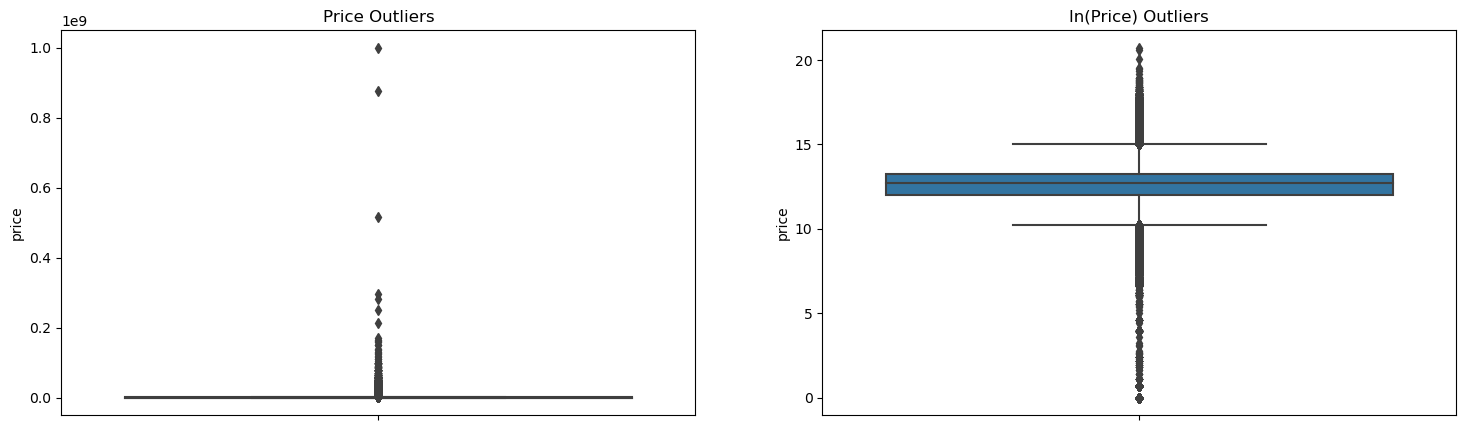

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(y=realtor_data['price'], ax=axes[0]).set_title('Price Outliers')
sns.boxplot(y=np.log1p(realtor_data['price']), ax=axes[1]).set_title('ln(Price) Outliers')
plt.show()

From the summary statistics and the outlier plots we can see that the max `price` is $1\times 10^9$, which is \$1 billion, however this is not realistic because, as of February 2024, the most expensive home in the United States is Gordon Pointe in Naples, Florida, which is listed for \$295 million dollars$^2$. Therefore we can filter `realtor_data` to not include the outliers in `price` that are greater than \$295 million dollars.$^2$ We can also see that the min is 0.0, meaning the home was free, however, this is not realistic and to avoid data entry errors, the lowest threshold will be set at \$10,000.

...

In [49]:
realtor_data = realtor_data[(realtor_data['price'] >= 1e4) & (realtor_data['price'] <= 2.95e8)]
realtor_data['price'] = winsorize_col(realtor_data['price'])

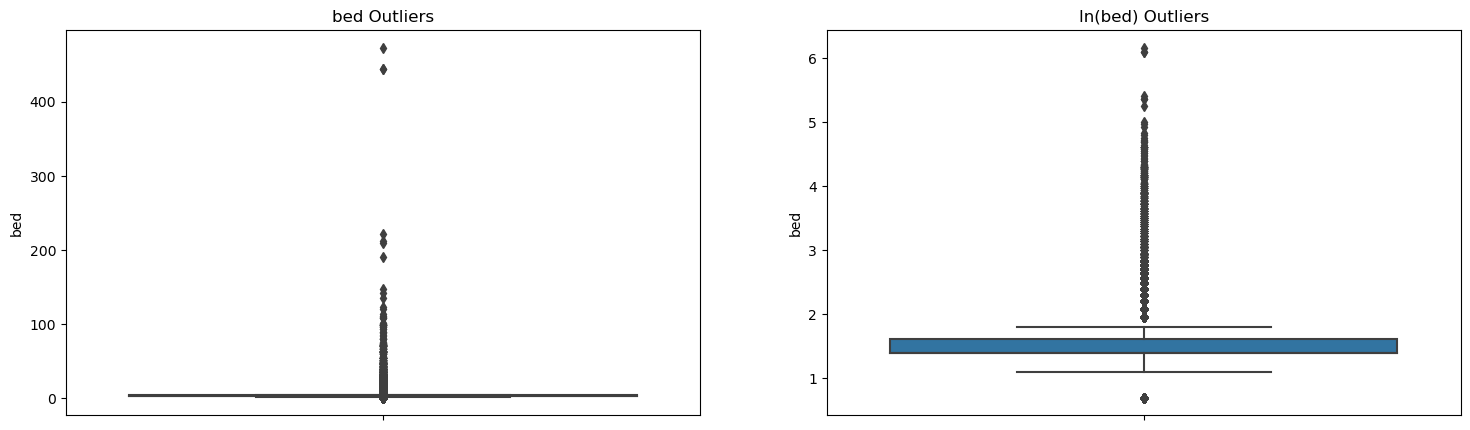

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(y=realtor_data['bed'], ax=axes[0]).set_title('bed Outliers')
sns.boxplot(y=np.log1p(realtor_data['bed']), ax=axes[1]).set_title('ln(bed) Outliers')
plt.show()

From the summary statistics we can see that the max `bed` is $473$, however this is not realistic because the Biltmore Estate in Asheville, North Carolina has the most amount of bedrooms in the United States at 35 $^3$. Therefore we can filter `realtor_data` to not include the outliers in `bed` that are greater than $35$.$^3$

In [51]:
realtor_data = realtor_data[realtor_data['bed']<=35]

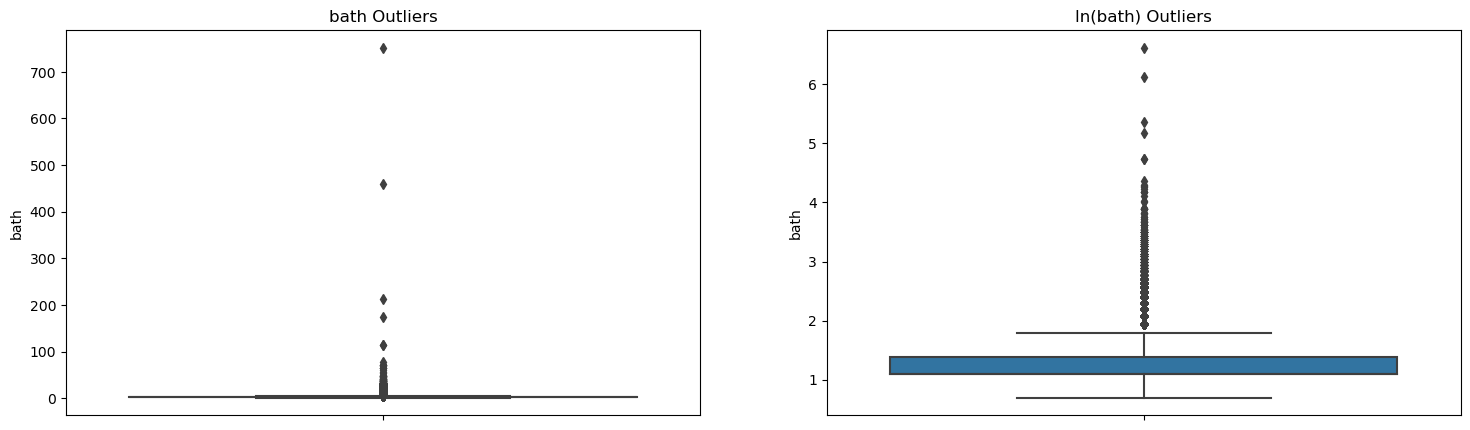

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(y=realtor_data['bath'], ax=axes[0]).set_title('bath Outliers')
sns.boxplot(y=np.log1p(realtor_data['bath']), ax=axes[1]).set_title('ln(bath) Outliers')
plt.show()

From the summary statistics we can see that the max `bath` is $752$, however this is not realistic because The One in Bel Air, California has the most amount of bathrooms in the United States at 49$^4$. Therefore we can filter `realtor_data` to not include the outliers in `bath` that are greater than $49$.$^4$

In [53]:
realtor_data = realtor_data[realtor_data['bath']<=49]

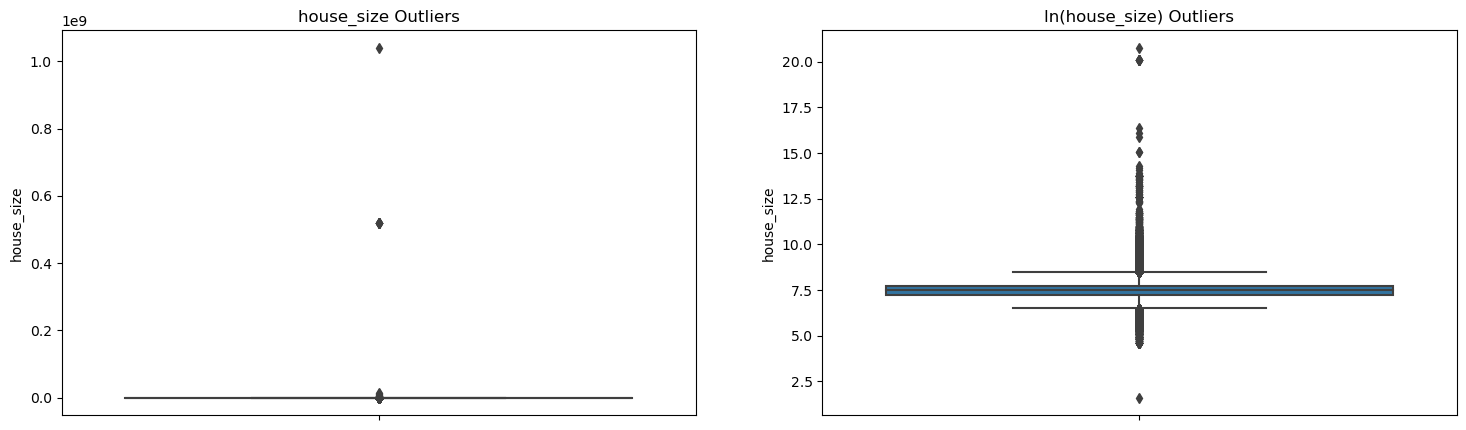

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(y=realtor_data['house_size'], ax=axes[0]).set_title('house_size Outliers')
sns.boxplot(y=np.log1p(realtor_data['house_size']), ax=axes[1]).set_title('ln(house_size) Outliers')
plt.show()

From the summary statistics we can see that the max `house_size` is $1.0404004\times 10^9$, which is around 1.04 billion, however this is not realistic because the Biltmore Estate in Asheville, North Carolina, the largest home in the United States by square footage, is at 175,000 sq ft$^5$. Therefore we can filter `realtor_data` to not include the outliers in `house_size` that are greater than $175,000$.$^5$

In [55]:
realtor_data = realtor_data[realtor_data['house_size']<=175_000]
realtor_data['house_size'] = winsorize_col(realtor_data['house_size'])

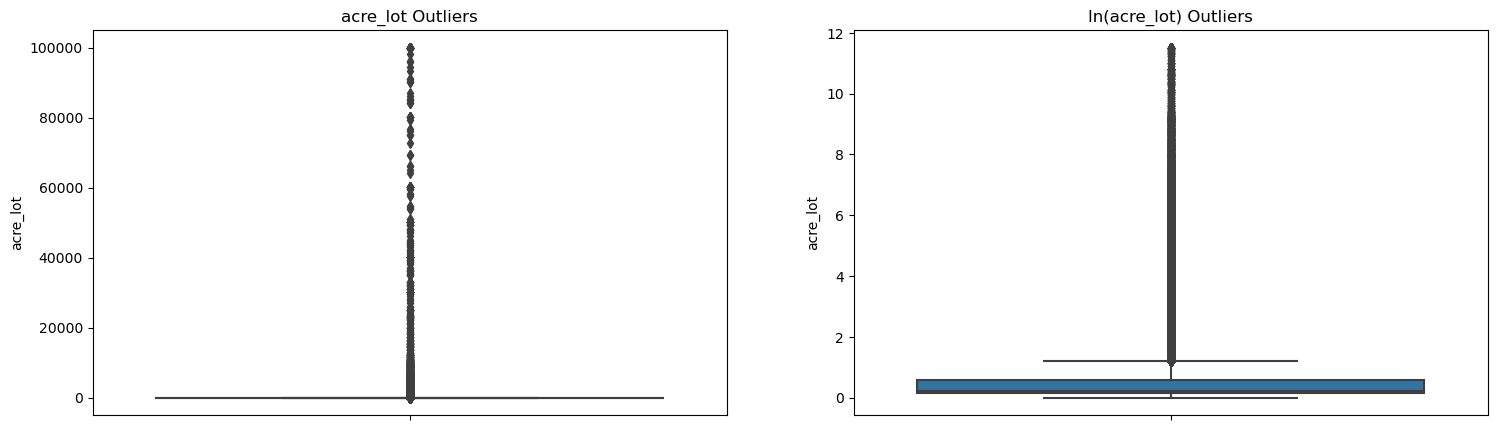

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(y=realtor_data['acre_lot'], ax=axes[0]).set_title('acre_lot Outliers')
sns.boxplot(y=np.log1p(realtor_data['acre_lot']), ax=axes[1]).set_title('ln(acre_lot) Outliers')
plt.show()

...

In [57]:
realtor_data['acre_lot'] = winsorize_col(realtor_data['acre_lot'])

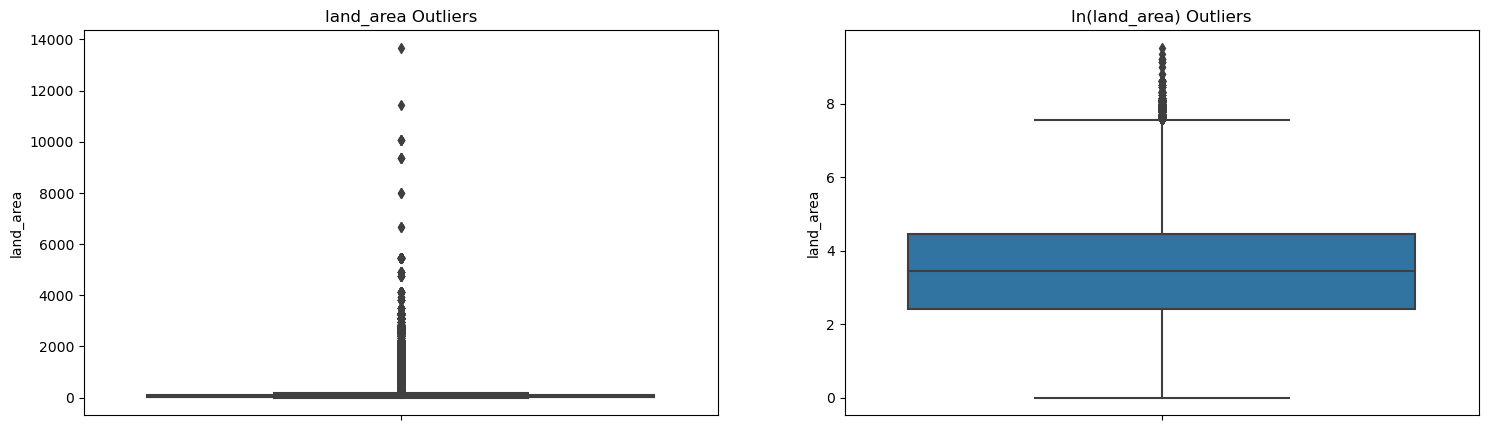

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(y=realtor_data['land_area'], ax=axes[0]).set_title('land_area Outliers')
sns.boxplot(y=np.log1p(realtor_data['land_area']), ax=axes[1]).set_title('ln(land_area) Outliers')
plt.show()

In [59]:
realtor_data['land_area'] = winsorize_col(realtor_data['land_area'])

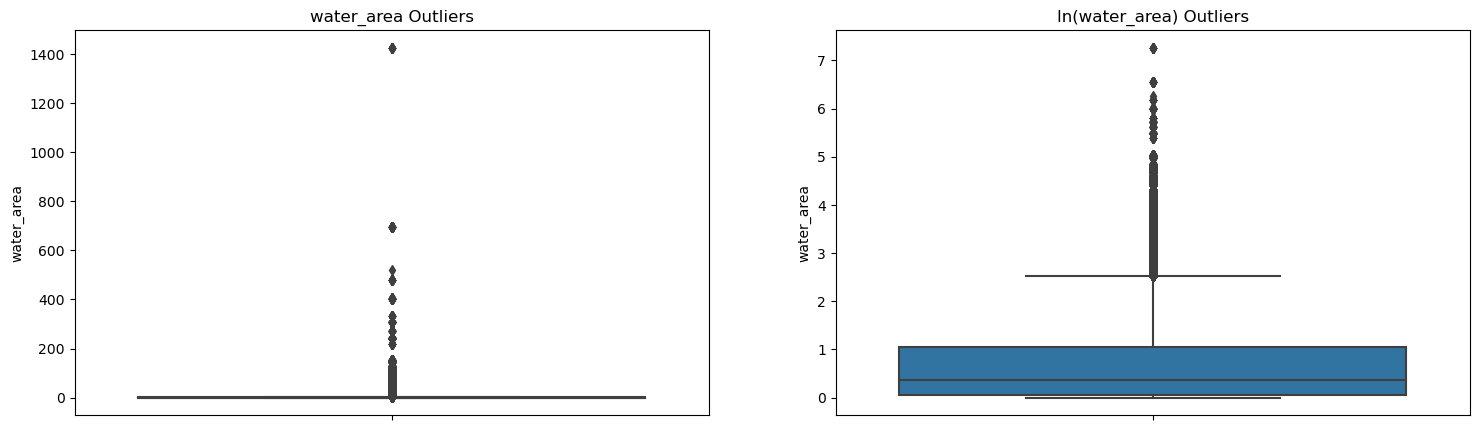

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(y=realtor_data['water_area'], ax=axes[0]).set_title('water_area Outliers')
sns.boxplot(y=np.log1p(realtor_data['water_area']), ax=axes[1]).set_title('ln(water_area) Outliers')
plt.show()

In [61]:
realtor_data['water_area'] = winsorize_col(realtor_data['water_area'])

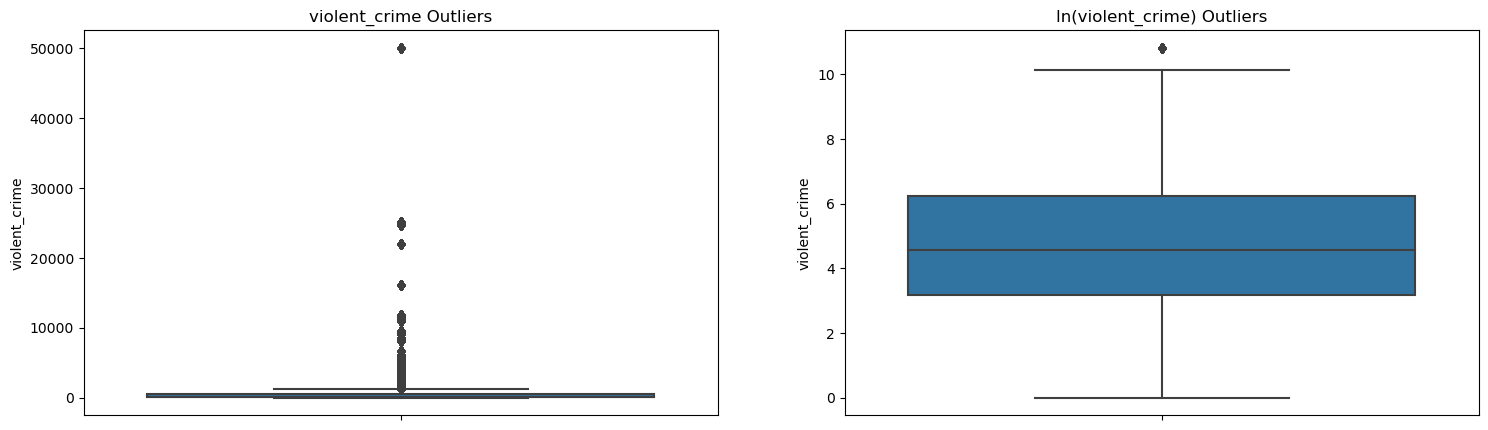

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(y=realtor_data['violent_crime'], ax=axes[0]).set_title('violent_crime Outliers')
sns.boxplot(y=np.log1p(realtor_data['violent_crime']), ax=axes[1]).set_title('ln(violent_crime) Outliers')
plt.show()

In [63]:
realtor_data['violent_crime'] = winsorize_col(realtor_data['violent_crime'])

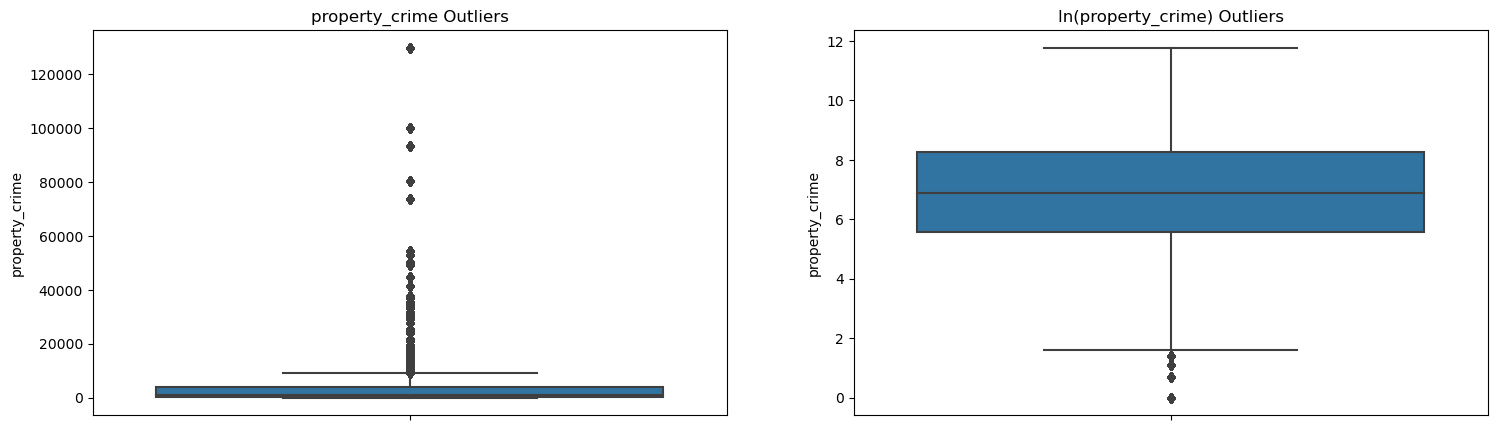

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(y=realtor_data['property_crime'], ax=axes[0]).set_title('property_crime Outliers')
sns.boxplot(y=np.log1p(realtor_data['property_crime']), ax=axes[1]).set_title('ln(property_crime) Outliers')
plt.show()

In [65]:
realtor_data['property_crime'] = winsorize_col(realtor_data['property_crime'])

In [66]:
realtor_data_copy = realtor_data.copy()

In [67]:
num_cols = realtor_data.select_dtypes(include=['float64', 'int64']).columns
num_cols = [i for i in num_cols if i not in ['bed', 'bath', 'property_tax', 'crime_rate', 'crime_rate', 'nearest_zip_distance', 'total_crime']]
skewed_feats = realtor_data[num_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
high_skew = skewed_feats[skewed_feats >= 1.0].index
realtor_data[high_skew] = np.log1p(realtor_data[high_skew])
realtor_data['total_crime'] = realtor_data['property_crime'] + realtor_data['violent_crime']
realtor_data['crime_rate'] = (realtor_data['total_crime']/realtor_data['population']) * 1_000

Cleaned summary stats

In [68]:
summary_stats = realtor_data.describe().T
summary_stats['std'] = summary_stats['std'].apply(lambda x: f"{x:.6f}")
summary_stats['max'] = summary_stats['max'].apply(lambda x: f"{x:.1f}")
display(summary_stats)

,count,mean,std,min,25%,50%,75%,max
price,2200928.0,12.579661,1.064879,9.615872,12.042971,12.700772,13.217675,15.2
bed,2200928.0,3.225658,1.128150,1.000000,3.000000,3.000000,4.000000,35.0
bath,2200928.0,2.432646,1.100958,1.000000,2.000000,2.000000,3.000000,49.0
acre_lot,2200928.0,0.567700,0.839784,0.019803,0.139762,0.223144,0.570980,4.4
house_size,2200928.0,7.490001,0.419728,6.447306,7.234177,7.477604,7.732369,8.7
land_area,2200928.0,3.447160,1.352506,0.553310,2.406044,3.453853,4.465920,6.6
water_area,2200928.0,0.693074,0.825413,0.000000,0.061095,0.359770,1.046968,3.5
latitude,2200928.0,36.750704,5.541792,19.065548,33.011304,37.144971,40.870240,71.3
longitude,2200928.0,-92.259891,15.908530,-164.654295,-98.487889,-87.598390,-80.587633,-67.0
population,2200928.0,27576.988973,19304.146942,1.000000,12248.000000,25161.000000,39020.000000,122814.0


In [69]:
display(realtor_data.dtypes)
display(realtor_data.columns)

brokered_by                     object
status                          object
price                          float64
bed                              int64
bath                             int64
acre_lot                       float64
street                          object
city                            object
state                           object
zip_code                        object
house_size                     float64
prev_sold_date          datetime64[ns]
first_time                    category
land_area                      float64
water_area                     float64
latitude                       float64
longitude                      float64
population                     float64
density                        float64
violent_crime                  float64
property_crime                 float64
closest_uni_name                object
closest_uni_lat                float64
closest_uni_lon                float64
closest_uni_zip                 object
closest_uni_obereg       

Index(['brokered_by', 'status', 'price', 'bed', 'bath', 'acre_lot', 'street',
       'city', 'state', 'zip_code', 'house_size', 'prev_sold_date',
       'first_time', 'land_area', 'water_area', 'latitude', 'longitude',
       'population', 'density', 'violent_crime', 'property_crime',
       'closest_uni_name', 'closest_uni_lat', 'closest_uni_lon',
       'closest_uni_zip', 'closest_uni_obereg', 'closest_uni_hloffer',
       'distance_to_uni', 'median_zip_price', 'inventory_count', 'nearest_zip',
       'nearest_zip_distance', 'total_crime', 'crime_rate', 'property_tax',
       'rank'],
      dtype='object')

In [70]:
# ---- GEODEMOGRAPHIC SEGMENTATION (Region-Based Classification) ----
region_column = "zip_code"

# Compute **regional** statistics using **median** instead of upper quartiles for acreage
region_stats = realtor_data.groupby(region_column).agg(
    price_25=("price", lambda x: x.quantile(0.25)),
    price_50=("price", lambda x: x.quantile(0.50)),
    price_75=("price", lambda x: x.quantile(0.75)),
    price_90=("price", lambda x: x.quantile(0.90)),
    size_25=("house_size", lambda x: x.quantile(0.25)),
    size_50=("house_size", lambda x: x.quantile(0.50)),
    size_75=("house_size", lambda x: x.quantile(0.75)),
    size_90=("house_size", lambda x: x.quantile(0.90)),
    crime_25=("crime_rate", lambda x: x.quantile(0.25)),
    crime_75=("crime_rate", lambda x: x.quantile(0.75)),
    tax_25=("property_tax", lambda x: x.quantile(0.25)),
    tax_75=("property_tax", lambda x: x.quantile(0.75)),
    density_50=("density", lambda x: x.median()),  
    acre_median=("acre_lot", lambda x: x.median()) )

def classify_home(row, region_stats):
    region = row[region_column]
    if region not in region_stats.index:
        return "Other"
    q = region_stats.loc[region]
    acre_median = q["acre_median"]
    if row["price"] >= q["price_90"] and row["house_size"] >= q["size_90"] and row["acre_lot"] >= 2 * acre_median:
        return "Luxury Estate"
    if row["acre_lot"] >= 1.5 * acre_median and row["price"] < q["price_90"]:
        return "Ranch Home"
    if row["price"] >= q["price_90"] and row["house_size"] >= q["size_90"]:
        return "Luxury Home"
    if row["bed"] >= 3 and row["bath"] >= 2 and q["price_25"] < row["price"] <= q["price_75"]:
        return "Family Home"
    if row["price"] <= q["price_25"] and row["house_size"] <= q["size_25"]:
        return "Tiny Home"
    if row["crime_rate"] >= q["crime_75"] or row["property_tax"] >= q["tax_75"] or row["house_size"] <= q["size_25"]:
        return "Investment Property"
    return "Other"

realtor_data["house_category"] = realtor_data.apply(lambda row: classify_home(row, region_stats), axis=1)

region_home_stats = realtor_data.groupby([region_column, "house_category"]).agg(
    total_listings=("price", "count"),
    median_price=("price", "median"),
    median_size=("house_size", "median"),
    crime_rate_median=("crime_rate", "median"),
    property_tax_median=("property_tax", "median"),
    median_acreage=("acre_lot", "median") 
).reset_index()

# plt.figure(figsize=(12, 6))
# sns.boxplot(x="house_category", y="price", data=realtor_data, order=[
#     "Tiny Home", "Investment Property", "Family Home", "Ranch Home", 
#     "Luxury Home", "Luxury Estate", "Other"
# ])
# plt.xticks(rotation=45)
# plt.title("Price Distribution by House Category")
# plt.ylabel("Price ($)")
# plt.xlabel("House Category")
# plt.grid(axis="y", linestyle="--", alpha=0.7)
# plt.show()

# plt.figure(figsize=(12, 6))
# sns.boxplot(x="house_category", y="house_size", data=realtor_data, order=[
#     "Tiny Home", "Investment Property", "Family Home", "Ranch Home", 
#     "Luxury Home", "Luxury Estate", "Other"
# ])
# plt.xticks(rotation=45)
# plt.title("House Size Distribution by Category")
# plt.ylabel("House Size (sq ft)")
# plt.xlabel("House Category")
# plt.grid(axis="y", linestyle="--", alpha=0.7)
# plt.show()

# plt.figure(figsize=(12, 6))
# sns.boxplot(x="house_category", y="acre_lot", data=realtor_data, order=[
#     "Tiny Home", "Investment Property", "Family Home", "Ranch Home", 
#     "Luxury Home", "Luxury Estate", "Other"
# ])
# plt.xticks(rotation=45)
# plt.title("Acre Size Distribution by Category")
# plt.ylabel("Acre Size")
# plt.xlabel("House Category")
# plt.grid(axis="y", linestyle="--", alpha=0.7)
# plt.show()

print(realtor_data[[region_column, "price", "house_size", "house_category"]].head())

  zip_code      price  house_size       house_category
0     1001  12.100718    6.517671            Tiny Home
1     1001  10.126671    7.242798           Ranch Home
2     1001  12.042971    6.794587            Tiny Home
3     1001  12.396697    7.264730  Investment Property
4     1001  12.611374    7.414573  Investment Property


**Overview**
This analysis applies Ordinary Least Squares (OLS), Lasso Regression, and Elastic Net Regression to predict house prices. The goal is to evaluate the effectiveness of different models, interpret key features affecting price, and identify areas for improvement.

**1. Summary of Model Performance**
The table below presents the results of different regression models used in the analysis:

| Model         | R² Score | Feature Selection | Regularization |
|--------------|---------|----------------|---------------|
| **OLS**       | 0.592   | All features included | No regularization |
| **Lasso**     | ~0.592  | Excluded `latitude`, kept `longitude` | L1 penalty (feature selection) |
| **Elastic Net** | ~0.592  | Retained `latitude`, adjusted some coefficients | Balances L1 (Lasso) and L2 (Ridge) |

**Key Observations**
- All models produced **similar R² values (~0.592)**, indicating that feature selection had little impact on predictive performance.
- **Lasso removed `latitude` but retained `longitude`**, suggesting a high correlation between these two variables.
- **Elastic Net retained `latitude`**, indicating that it contains some unique information that contributes to price prediction.

**2. Interpretation of Key Findings**
**A. Model Fit and Performance**
- **R² = 0.592**: The models explain approximately 59.2% of the variation in house prices.
- **Adjusted R² = 0.592**: There is no substantial penalty for adding variables, suggesting that the selected features are relevant.
- **F-statistic = 266,100**: The model is statistically significant, with a very low probability of these results occurring by chance.
- **Durbin-Watson = 1.366**: Some evidence of positive autocorrelation in residuals, which suggests that prices may follow trends not fully captured by the model.

**B. Feature Importance and Coefficients**
The following table summarizes the most significant predictors of house price:

| Feature            | Coefficient | Interpretation |
|--------------------|------------|---------------|
| **Median Zip Price** | 0.6959  | Houses in higher-priced zip codes are significantly more expensive. |
| **House Size**     | 0.4320  | Larger houses increase price substantially. |
| **Acre Lot**       | 0.2398  | More land generally increases house prices. |
| **Bath**          | 0.5784  | Additional bathrooms contribute to higher prices. |
| **Latitude**       | 0.0032  | Geographic location influences house price. |
| **Longitude**      | -0.0048 | Longitude has a negative correlation, likely due to regional price differences. |
| **Crime Rate**     | 0.0065  | Higher crime rate is associated with higher prices, possibly due to urban clustering. |

**C. Interpretation of Crime Rate and Density Relationship**
The positive relationship between crime rate and house price is counterintuitive. This may indicate:
- An **urban effect** where higher crime rates occur in densely populated areas that also have higher home prices.
- Potential **multicollinearity** with other urban-related variables, such as population density or zip code price levels.

**3. Further Investigation and Next Steps**
**A. Check for Multicollinearity (Variance Inflation Factor - VIF)**
To determine whether some features are redundant, it is necessary to calculate the Variance Inflation Factor (VIF)


- Observations  
    - Luxury Estates and Luxury Homes have the highest median prices, with Luxury Estates having the widest price range.  
    - Ranch Homes and Family Homes fall in a mid-tier price range, but Ranch Homes show more variability.  
    - Investment Properties and Tiny Homes have the lowest median prices, with Tiny Homes showing the least variation.  
    - Luxury Homes and Luxury Estates have several high-value outliers, indicating that some properties are significantly more expensive than the median.  

- Interpretation  
    - It is expected that Luxury Estates command the highest prices, as they include expansive properties in prime locations.  
    - Ranch Homes appear to have a broad price distribution, which could be due to differences in land value across regions.  
    - Investment Properties show high variation, suggesting the category includes both affordable rental units and high-value investment assets.  
    - The Other category remains inconsistent, indicating that it might contain unclassified properties such as mobile homes or mixed-use spaces.  

- Observations  
    - Luxury Estates have the largest homes, with a substantial range in size.  
    - Family Homes, Luxury Homes, and Ranch Homes are in a similar size range, though Ranch Homes show more variation.  
    - Tiny Homes are the smallest, as expected, followed by Investment Properties, which have moderate variation.  
    - Luxury Estates and Luxury Homes have a wide distribution of sizes, suggesting the inclusion of both high-end apartments and large estates.  

- Interpretation  
    - Family Homes having larger median sizes than Tiny Homes aligns with expectations, as they are designed for larger households.  
    - The wide range in Ranch Home sizes suggests that some may be large, multi-acre properties, while others could be smaller homes with significant land.  
    - Investment Properties showing variation in size suggests a mix of rental units, duplexes, and larger income-generating properties.  
    - The relatively small size distribution of Tiny Homes reflects a niche market targeting affordability and compact living.  

- Observations  
    - Ranch Homes and Luxury Estates have the largest acre sizes, with Luxury Estates showing the widest range.  
    - Family Homes, Tiny Homes, and Investment Properties have significantly smaller acre sizes, as expected.  
    - Luxury Homes do not require large land areas, reinforcing the distinction between Luxury Homes and Luxury Estates.  
    - The Other category includes properties with variable acre sizes, suggesting mixed property classifications.  

- Interpretation  
    - Ranch Homes having large acre sizes but mid-tier prices aligns with expectations, as these homes prioritize land over house size.  
    - Luxury Estates, which have both large acre sizes and high prices, appear correctly classified.  
    - The presence of large-acre properties in the Other category may indicate incomplete classifications or edge cases.  
    - The relatively small land size of Tiny Homes and Investment Properties is expected, as these properties are typically located in dense urban areas or are compact rental units.  

- Conclusion  
    - The distribution of house prices, sizes, and acreages across categories aligns with market trends. Luxury Estates and Luxury Homes tend to be larger and more expensive, while Tiny Homes and Investment Properties remain compact and more affordable. Ranch Homes show a distinct trend, prioritizing land size over price. The classification model appears reasonable, but additional refinement in the Other category and further validation using location-based data could enhance accuracy.



**Univariate Analysis**

for col in (realtor_data.select_dtypes(include=['float64', 'int64']).columns):
    plt.figure(figsize=(8, 4))
    sns.histplot(realtor_data[col], kde=True, stat='density', bins=20)
    plt.title(f'Distribution of {col}')
    plt.show()

Distributions of the numeric features

numeric_cols = ['price', 'bed', 'bath', 'acre_lot', 'house_size']
sampled_data = realtor_data.sample(100000, random_state=42)  # Sample 100K rows

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for ax, col in zip(axes.flatten(), numeric_cols[:4]):
    sns.histplot(data=sampled_data, x=col, kde=True, stat="density", kde_kws={"bw_adjust": 5}, bins=25, ax=ax)
    ax.set_title(col)
    if col in ['bed', 'bath']:
        ax.set_xlabel(f'{col} (unit of 1)')
    elif col == 'price':
        ax.set_xlabel(f'{col} (millions $)')
    else:
        ax.set_xlabel(f'{col} (acres)')

plt.figure(figsize=(4, 3))
sns.histplot(data=sampled_data, x=numeric_cols[4], kde=True, stat="density", kde_kws={"bw_adjust": 5}, bins=25)
plt.title(numeric_cols[4])
plt.xlabel(f'{numeric_cols[4]} (sq ft)')
plt.show()

Since the histograms of `price`, `acre_lot`, and `house_size` show extreme right-skewness, we will apply a log transformation to spread out the lower values.

RE_data = realtor_data

# Price
fig, ax = plt.subplots(figsize=(6, 5))
sns.histplot(data=realtor_data, x=np.log10(realtor_data['price'] + 1), kde=True, bins=50, ax=ax)
ax.set_title("Log-Transformed Standardized Price Distribution")
ax.set_xlabel("log10(price)")
plt.show()

# acre_lot
fig, ax = plt.subplots(figsize=(6, 5))
sns.histplot(data=realtor_data, x=np.log10(realtor_data['acre_lot'] + 1), kde=False, bins=30, ax=ax)
ax.set_title("Log-Transformed Standardized acre_lot Distribution")
ax.set_xlabel("log10(acre_lot)")
plt.show()

# Q-Q plot
fig, ax = plt.subplots(figsize=(6, 5))
stats.probplot(np.log10(realtor_data['acre_lot'] + 1), dist="norm", plot=ax)
ax.set_title("Q-Q Plot of Log-Transformed acre_lot")
plt.show()

# Plotting log-transformed standardized values for 'price' and 'acre_lot'
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for ax, col in zip(axes.flatten(), ['price', 'acre_lot']):
    # Plot log-transformed standardized values
    sns.histplot(data=realtor_data_copy, x=np.log1p(realtor_data_copy[col]), kde=True, bins=30, ax=ax)
    ax.set_title(f"Log-Transformed {col}")
    ax.set_xlabel(f"log10({col})")

plt.show()

# Plotting for 'house_size'
fig, ax = plt.subplots(figsize=(6, 5))
sns.histplot(data=realtor_data_copy, x=np.log1p(realtor_data_copy['house_size']), kde=True, bins=30)
ax.set_title("Log-Transformed house_size")
ax.set_xlabel("log10(house_size)")
plt.show()

# Ensure only numeric columns are considered
numeric_cols = realtor_data.select_dtypes(include=['number']).columns

# Compute skewness only for numeric columns
skewed_cols = numeric_cols[realtor_data[numeric_cols].skew() > 2].tolist()

# Apply log transformation for highly skewed columns
realtor_data[skewed_cols] = realtor_data[skewed_cols].apply(lambda x: np.log1p(x))

print(f"Log-transformed columns: {skewed_cols}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before log transformation
sns.violinplot(y=realtor_data_copy['price'], ax=axes[0], color='blue')
axes[0].set_title('Price Distribution (Original)')

# After log transformation
sns.violinplot(y=np.log1p(realtor_data['price']), ax=axes[1], color='red')
axes[1].set_title('Price Distribution (Log-Transformed)')

plt.show()

numeric_data = realtor_data.select_dtypes(include=['number'])
plt.figure(figsize=(20, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(x='status', data=realtor_data, hue='status', palette='coolwarm')
plt.title("Distribution of Status by Color")
plt.show()


RE = realtor_data

outlier_list = ['price','bed','house_size']
max = 3
for i in outlier_list:
    z_scores = np.abs((RE_data[i] - RE_data[i].mean()) / RE_data[i].std())
    RE_data = RE_data[z_scores <= max]

**Avg house size by state**

avg_house_size = RE_data[['state','house_size']]\
                .groupby('state')\
                .mean()\
                .sort_values('house_size')\
                .rename(columns={'house_size':'House Size'})
avg_house_size.index.name = 'State'

avg_house_size.plot(kind='bar');
plt.title('Average House Size by State');
plt.ylabel('Average House Size');

**Price range frequency**

num_bins = 20
price_range = (0,100)

hist_price = pd.cut(RE_data['price'], bins=num_bins)

dist_houseprice = hist_price.value_counts().sort_index().round(2).plot(kind='bar');

plt.xlabel('Price Range')
plt.ylabel('Frequency')

dist_houseprice;

**Price distribution on bedroom**

def as_millions(value):
    return value/1_000_000


avg_price_bdr = RE_data[['price','bed']]\
                .groupby('bed')\
                .mean()\
                .rename(columns={'price':'Price'})\
                .apply(as_millions)
    
avg_price_bdr.index.name = "Bedroom"

avg_price_bdr

avg_price_bdr.plot(kind='bar')
plt.ylabel('Price (in MMs)');

**Avg price of State**

avg_price_state = RE_data[['state','price']]\
                .groupby('state')\
                .mean()\
                .sort_values('price')\
                .rename(columns={'price':'Price'})
avg_price_state.index.name = 'State'

avg_price_state.plot(kind='bar')
plt.ylabel('Price')
plt.title('Average Home Price of State');

**Highest Average Home Price accross citys**

avg_price_city = RE_data[['city','price']]\
                .groupby('city')\
                .mean()\
                .nlargest(10,'price')\
                .rename(columns={'price':'Price'})
avg_price_city.index.name = 'City'

avg_price_city['Price'] = avg_price_city['Price'].apply(as_millions) 
                
avg_price_city

avg_price_city.plot(kind='bar');
plt.ylabel('Price (in MMs)');
plt.title('Top Ten Cities with Highest Average Home Prices');

## Baseline Models

**Preprocessing Features**

In [71]:
feature_cols = ["median_zip_price", "house_size", "acre_lot", 
                "bath", "latitude", "longitude", "crime_rate"]
X = realtor_data[feature_cols]
y = realtor_data["price"]  
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

**Linear Regression**

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

**Random Forest Regressor**

rf_reg = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=10
)
rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

**XGBoost Regressor**

xgb_reg = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    verbosity=1
)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

**LightGBM**

lgb_reg = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42
)
lgb_reg.fit(X_train, y_train)
y_pred = lgb_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

**Lasso Regression**

lasso_reg = Lasso(alpha=0.01)
lasso_reg.fit(X_train, y_train)
y_pred_lasso = lasso_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"RMSE: {rmse:.2f}")

**Ridge Regression**

ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f"RMSE: {rmse:.2f}")

## Final Model

In [72]:
X = realtor_data.drop('price', axis=1)
y = realtor_data['price']
X['prev_sold_year'] = X['prev_sold_date'].dt.year
X['prev_sold_month'] = X['prev_sold_date'].dt.month
X['prev_sold_day'] = X['prev_sold_date'].dt.day
X = X.drop(columns=['prev_sold_date'])

categorical_cols = X.select_dtypes(include=['object']).columns
encoder = LabelEncoder()
for col in categorical_cols:
    X[col] = encoder.fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt', 
    'num_leaves': 100,        # From RandomizedSearchCV
    'max_depth': 20,          # From RandomizedSearchCV
    'learning_rate': 0.1,     # From RandomizedSearchCV
    'lambda_l1': 1.0,         # From RandomizedSearchCV      
    'lambda_l2': 1.0,         # From RandomizedSearchCV      
    'feature_fraction': 1,  # From RandomizedSearchCV
    'bagging_fraction': 0.8,  # From RandomizedSearchCV     
}

model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=1000)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6715
[LightGBM] [Info] Number of data points in the train set: 1760742, number of used features: 38
[LightGBM] [Info] Start training from score 12.580133
RMSE: 0.41


**RandomSearchCV**

In [73]:
# param_dist = {
#     'num_leaves': [31, 50, 100],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [-1, 10, 20],
#     'feature_fraction': [0.6, 0.8, 1.0],
#     'bagging_fraction': [0.6, 0.8, 1.0],
#     'lambda_l1': [0.1, 0.5, 1.0],
#     'lambda_l2': [0.1, 0.5, 1.0],
# }

# lgb_model = lgb.LGBMRegressor(objective='regression', metric='rmse')

# random_search = RandomizedSearchCV(lgb_model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2)
# random_search.fit(X_train, y_train)

# print(f"Best parameters: {random_search.best_params_}")

**Important Features For the Model**

In [74]:
importances = model.feature_importance(importance_type='gain')
features = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                 Feature    Importance
26      median_zip_price  4.837365e+06
34        house_category  1.476547e+06
9             house_size  6.134539e+05
3                   bath  5.816400e+05
4               acre_lot  4.481432e+05
16               density  1.054784e+05
27       inventory_count  1.049133e+05
2                    bed  9.650178e+04
5                 street  9.212687e+04
10            first_time  8.430762e+04
11             land_area  5.059362e+04
13              latitude  4.603798e+04
20       closest_uni_lat  4.542729e+04
15            population  4.505485e+04
23    closest_uni_obereg  4.024692e+04
7                  state  3.245766e+04
12            water_area  3.080950e+04
25       distance_to_uni  2.530202e+04
29  nearest_zip_distance  2.498998e+04
8               zip_code  2.495735e+04
14             longitude  2.482479e+04
1                 status  2.411204e+04
31            crime_rate  2.092792e+04
21       closest_uni_lon  2.024352e+04
6                   city 

## Home Evaluation and Association Rule Mining

In [75]:
realtor_data['prev_sold_year'] = realtor_data['prev_sold_date'].dt.year
realtor_data['prev_sold_month'] = realtor_data['prev_sold_date'].dt.month
realtor_data['prev_sold_day'] = realtor_data['prev_sold_date'].dt.day

X_features = realtor_data.drop(columns=['prev_sold_date', 'price'])

categorical_cols = X_features.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X_features[col] = encoder.fit_transform(X_features[col])

realtor_data['xPrice'] = model.predict(X_features, num_iteration=model.best_iteration)

In [76]:
realtor_data['price_diff'] = realtor_data['price'] - realtor_data['xPrice']
std_dev = realtor_data['price_diff'].std()
def categorize_valuation(diff, std_dev):
    if diff < -std_dev:
        return 'Undervalued'
    elif diff > std_dev:
        return 'Overvalued'
    else:
        return 'Properly Valued'

realtor_data['valuation'] = realtor_data['price_diff'].apply(lambda x: categorize_valuation(x, std_dev))
realtor_data.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date,first_time,land_area,water_area,latitude,longitude,population,density,violent_crime,property_crime,closest_uni_name,closest_uni_lat,closest_uni_lon,closest_uni_zip,closest_uni_obereg,closest_uni_hloffer,distance_to_uni,median_zip_price,inventory_count,nearest_zip,nearest_zip_distance,total_crime,crime_rate,property_tax,rank,house_category,prev_sold_year,prev_sold_month,prev_sold_day,xPrice,price_diff,valuation
0,67832,for sale,12.100718,2,1,0.292670,732726,agawam,massachusetts,1001,6.517671,2021-11-30,1,2.508949,0.599386,42.062368,-72.625754,17621.0,6.3347,4.343805,6.257668,bay path university,42.055088,-72.583382,01106,1,9,1.788056,12.396697,3.332205,1030,10.391737,10.601473,0.601639,1.11,17,Tiny Home,2021,11,30,11.615943,0.484775,Overvalued
1,97400,for sale,10.126671,3,2,1.483875,1909493,agawam,massachusetts,1001,7.242798,2021-11-30,1,2.508949,0.599386,42.062368,-72.625754,17621.0,6.3347,4.343805,6.257668,bay path university,42.055088,-72.583382,01106,1,9,1.788056,12.396697,3.332205,1030,10.391737,10.601473,0.601639,1.11,17,Ranch Home,2021,11,30,11.750796,-1.624125,Undervalued
2,58796,for sale,12.042971,2,2,0.343590,1194249,agawam,massachusetts,1001,6.794587,2019-04-30,0,2.508949,0.599386,42.062368,-72.625754,17621.0,6.3347,4.343805,6.257668,bay path university,42.055088,-72.583382,01106,1,9,1.788056,12.396697,3.332205,1030,10.391737,10.601473,0.601639,1.11,17,Tiny Home,2019,4,30,11.935597,0.107374,Properly Valued
3,8147,for sale,12.396697,2,2,0.343590,913299,agawam,massachusetts,1001,7.264730,2021-11-30,1,2.508949,0.599386,42.062368,-72.625754,17621.0,6.3347,4.343805,6.257668,bay path university,42.055088,-72.583382,01106,1,9,1.788056,12.396697,3.332205,1030,10.391737,10.601473,0.601639,1.11,17,Investment Property,2021,11,30,12.470693,-0.073996,Properly Valued
4,22700,for sale,12.611374,2,2,0.343590,560791,agawam,massachusetts,1001,7.414573,2021-11-30,1,2.508949,0.599386,42.062368,-72.625754,17621.0,6.3347,4.343805,6.257668,bay path university,42.055088,-72.583382,01106,1,9,1.788056,12.396697,3.332205,1030,10.391737,10.601473,0.601639,1.11,17,Investment Property,2021,11,30,12.644924,-0.033550,Properly Valued


In [78]:
realtor_data['valuation'].value_counts(normalize=True)

Properly Valued    0.793808
Undervalued        0.105263
Overvalued         0.100929
Name: valuation, dtype: float64